In [1]:
from brian2 import *
import numpy as np
from itertools import compress  
import matplotlib.pyplot as plt

'''
Obtaining postsynaptic indices from a wrapped Gaussian distribution. 

The inputs to the main function getsynInd include the coordinates of the presynaptic neurons (j1,j2) 
and the coordinates of the postsynaptic neurons (j1_post,j2_post). The inputs also include b, the 
width of the Gaussian, n, the upper bound or the edge of the 2-D lattice and k, the number of outgoing
connections. The helper function getwrappedDist returns k samples from a wrapped Gaussian distribution.

'''

def getwrappedDist(u,sigma,lb,ub,k):
        
    ind = (np.mod(np.round(np.random.normal(loc=u,scale=sigma,size=k))-lb,ub-lb)+lb)
        
    return ind.astype(int)
    
def getsynInd(j1,j2,j1_post,j2_post,b,n,k):

    x = np.empty(len(j1)*k); y = np.empty(len(j1)*k); 
    
    for i in np.arange(0,len(j1)):

        ind1 = getwrappedDist(j1[i],b,0,n,k);
        ind2 = getwrappedDist(j2[i],b,0,n,k);
        
        #print(ind1)
        
        x[k*i:(k*i)+k] = np.tile(i,(k))
        #y[k*i:(k*i)+k] = [int(j[np.logical_and((j1==ind1[a]),(j2==ind2[a]))]) for a in range(k)]
        
        for a in np.arange(0,k):
            
            #print(ind1[a],ind2[a])
            temp = np.logical_and((j1_post==ind1[a]),(j2_post==ind2[a]))        
            res = list(compress(range(len(temp)),temp))  
            
            #print(int(res[0]))
            y[k*i + a] = int(res[0])

        
        #print(len(x),len(y))
        
    return x.astype(int),y.astype(int)
        

In [9]:
# Main code for network simulation. 

defaultclock.dt = 1*ms

c=15

# excitatory neurons
tau_ref = 1.5*ms; tau_m = 15*ms
El = -60*mV; Vt = -50*mV; Dt_e = 2*mV; Vre = -65*mV; Vth = -10*mV

# inhibitory neurons
tau_m_i = 10*ms; Dt_i = 0.5*mV; tau_ref_i = 0.5*ms

# synapses
rows_p, cols_p = 25, 25
rows_e, cols_e = 100, 100
rows_i, cols_i = 50, 50

N = rows_e*rows_e + rows_i*rows_i

p_fe = 0.1; p_fi = 0.05;
p_ee = 0.01; p_ei = 0.03; p_ie = 0.04; p_ii = 0.04

j_fe = (140/np.sqrt(N))*mV; j_fi = (100/np.sqrt(N))*mV;
j_ee = (80/np.sqrt(N))*mV; j_ei = (40/np.sqrt(N))*mV; 
j_ie = (240/np.sqrt(N))*mV; j_ii = (300/np.sqrt(N))*mV; 

sig_ffwd = 0.05; sig_rec = 0.1

b_fe = sig_ffwd*rows_e; k_fe = int(p_fe*rows_e*rows_e);
b_fi = sig_ffwd*rows_i; k_fi = int(p_fi*rows_i*rows_i);

b_ee = sig_rec*rows_e; k_ee = int(p_ee*rows_e*rows_e);
b_ii = sig_rec*rows_i; k_ii = int(p_ii*rows_i*rows_i);
b_ei = sig_rec*rows_i; k_ei = int(p_ei*rows_i*rows_i);
b_ie = sig_rec*rows_e; k_ie = int(p_ie*rows_e*rows_e);


j_a = (100/np.sqrt(N))*mV; # adaptation magnitude

# synapse equations
tau_re = 1*ms; tau_de = 5*ms;
tau_ra = 1*ms; tau_da = 375*ms; # adaptation time constant
tau_ri = 1*ms; tau_di = 8*ms;

# equations for excitatory neurons
eqns_e = '''
dV_e/dt = (-(V_e-El) + Dt_e*exp((V_e-Vt)/Dt_e) + I_e + I_ie + I_a)/tau_m : volt

dI_e/dt = (-I_e + a_e)/tau_de : volt
da_e/dt = -a_e/tau_re : volt

dI_a/dt = (-I_a + a_a)/tau_da : volt
da_a/dt = -a_a/tau_ra : volt

dI_ie/dt = (-I_ie + a_ie)/tau_di : volt
da_ie/dt = -a_ie/tau_ri : volt
'''

# equations for inhibitory neurons
eqns_i = '''
dV_i/dt = (-(V_i-El) + Dt_i*exp((V_i-Vt)/Dt_i) + I_i + I_fi)/tau_m_i : volt

dI_i/dt = (-I_i + a_i)/tau_di : volt
da_i/dt = -a_i/tau_ri : volt

dI_fi/dt = (-I_fi + a_fi)/tau_de : volt
da_fi/dt = -a_fi/tau_re : volt
'''


G_e = NeuronGroup(rows_e * cols_e, eqns_e, threshold='V_e>Vth', reset='V_e=-65*mV', refractory=tau_ref, method='euler')
G_e.V_e = ((Vre - Vth)*np.random.rand(rows_e*cols_e)) + Vre


G_i = NeuronGroup(rows_i * cols_i, eqns_i, threshold='V_i>Vth', reset='V_i=-65*mV', refractory=tau_ref_i, method='euler')
G_i.V_i = ((Vre - Vth)*np.random.rand(rows_i*cols_i)) + Vre

# layer 1 poisson neurons

P = NeuronGroup(rows_p * cols_p, 'rate : Hz', threshold='rand() < rate*dt', method='euler')
P.rate = 10*Hz


## Layer 1 to Layer 2 feedforward connections

# Fe connections

eqns_fe = '''
w : volt
w_a : volt
'''

eqns_act_fe = '''

a_e+=w
a_a+=w_a

'''

S_fe = Synapses(P, G_e, eqns_fe, on_pre=eqns_act_fe)

x = np.arange(0,rows_p*rows_p)
x1 = (x//rows_p)*(rows_e/rows_p); x2 = np.mod(x,rows_p)*(rows_e/rows_p);

x_post = np.arange(0,rows_e*rows_e)
x1_post = x_post//rows_e; x2_post = np.mod(x_post,rows_e)

i,j = getsynInd(x1,x2,x1_post,x2_post,b_fe,rows_e,k_fe)
#print(i,j)

S_fe.connect(i=i,j=j)

S_fe.w = j_fe*c
S_fe.w_a = -j_a*c

# Fi connections

S_fi = Synapses(P, G_i, 'w:volt', on_pre='a_fi+=w')

x = np.arange(0,rows_p*rows_p)
x1 = (x//rows_p)*(rows_i/rows_p); x2 = np.mod(x,rows_p)*(rows_i/rows_p);

x_post = np.arange(0,rows_i*rows_i)
x1_post = x_post//rows_i; x2_post = np.mod(x_post,rows_i)

i,j = getsynInd(x1,x2,x1_post,x2_post,b_fi,rows_i,k_fi)

S_fi.connect(i=i,j=j)

S_fi.w = j_fi*c


## Layer 2 connections


# ee connections
eqns_ee = '''
w:volt
w_a:volt
'''

eqns_act_ee = '''

a_e+=w
a_a+=w_a

'''
S_ee = Synapses(G_e, G_e, eqns_ee, on_pre=eqns_act_ee)

x = np.arange(0,rows_e*rows_e)
x1 = x//rows_e; x2 = np.mod(x,rows_e);

i,j = getsynInd(x1,x2,x1,x2,b_ee,rows_e,k_ee)

S_ee.connect(i=i,j=j)
S_ee.w = j_ee*c
S_ee.w_a = -j_a*c

# ii connections

S_ii = Synapses(G_i, G_i, 'w:volt', on_pre='a_i+=w')

x = np.arange(0,rows_i*rows_i)
x1 = x//rows_i; x2 = np.mod(x,rows_i);

i,j = getsynInd(x1,x2,x1,x2,b_ii,rows_i,k_ii)

S_ii.connect(i=i,j=j)
S_ii.w = -j_ii*c

# ei connections

S_ei = Synapses(G_e, G_i, 'w:volt', on_pre='a_i+=w')

x = np.arange(0,rows_e*rows_e)
x1 = (x//rows_e)*(rows_i/rows_e); x2 = np.mod(x,rows_e)*(rows_i/rows_e);

x_post = np.arange(0,rows_i*rows_i)
x1_post = x//rows_i; x2_post = np.mod(x,rows_i)

i,j = getsynInd(x1,x2,x1_post,x2_post,b_ei,rows_i,k_ei)

S_ei.connect(i=i,j=j)

S_ei.w = j_ei*c

# ie connections

S_ie = Synapses(G_i, G_e, 'w:volt', on_pre='a_ie+=w')

x = np.arange(0,rows_i*rows_i)
x1 = (x//rows_i)*(rows_e/rows_i); x2 = np.mod(x,rows_i)*(rows_e/rows_i);

x_post = np.arange(0,rows_e*rows_e)
x1_post = x_post//rows_e; x2_post = np.mod(x_post,rows_e)

i,j = getsynInd(x1,x2,x1_post,x2_post,b_ie,rows_e,k_ie)


S_ie.connect(i=i,j=j)

S_ie.w = -j_ie*c


M_Ge = SpikeMonitor(G_e,variables=['V_e'])
Ms_Ge = StateMonitor(G_e,variables=['V_e','I_e','I_ie','I_a'], record=[0, 1, 2, 3, 4, 5])

MP_Ge = PopulationRateMonitor(G_e)

run(5*second)
'''
data1 = M_Ge.get_states(['V_e'])
with open('M_Ge.pickle', 'wb') as f:
    pickle.dump(data1, f)

i,t = Ms_Ge.it

i = np.asarray(i); t = np.asarray(t)

with open('Ms_Ge.pickle', 'wb') as f:
    pickle.dump((i,t), f)

'''


"\ndata1 = M_Ge.get_states(['V_e'])\nwith open('M_Ge.pickle', 'wb') as f:\n    pickle.dump(data1, f)\n\ni,t = Ms_Ge.it\n\ni = np.asarray(i); t = np.asarray(t)\n\nwith open('Ms_Ge.pickle', 'wb') as f:\n    pickle.dump((i,t), f)\n\n"

(100, 300)

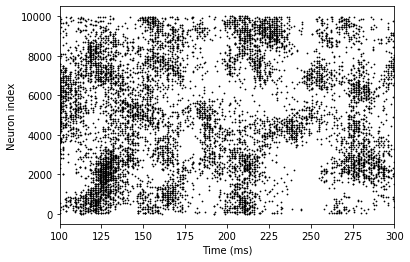

In [18]:
import matplotlib.pyplot as plt

i, t = M_Ge.it
plot(t/ms, i, 'k.', ms=1.5)

plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')

xlim(100,300)

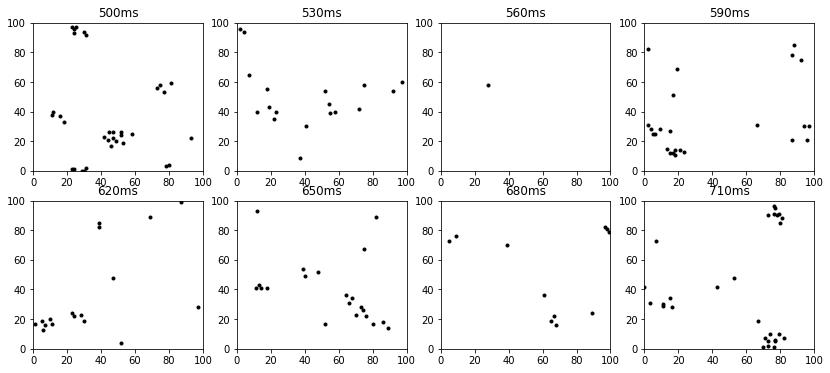

In [23]:
import matplotlib.pyplot as plt


spikeTimes = np.round(t/msecond)
t_pts = [500,530,560, 590, 620,650,680,710]

fig = plt.figure(figsize=(14,6))

for ind,k in enumerate(t_pts):
        
    x1 = i[spikeTimes == k]//100
    x2 = np.mod(i[spikeTimes == k],100)

    ax = fig.add_subplot(2,4,ind+1)
    ax.plot(x1,x2, 'k' + '.')

    xlim(0,100); ylim(0,100)
    
    title(str(k)+'ms')

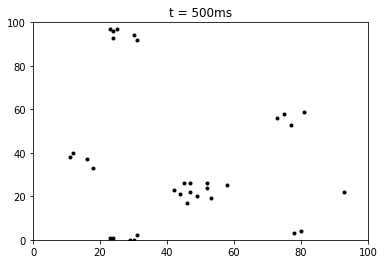

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


ind, t = M_Ge.it

spikeTimes = np.round(t/msecond)

fig, ax = plt.subplots(1, 1)

def animate(i,ind,spikeTimes):

    plt.clf()
    plt.plot(ind[spikeTimes == i]//100, np.mod(ind[spikeTimes == i],100), 'k' + '.')
    xlim(0,100);ylim(0,100)
    title('t = '+str(i)+'ms')

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate,fargs = (ind,spikeTimes), frames=np.arange(500,800,1), \
                                     repeat=True)

HTML(myAnimation.to_html5_video())


In [ ]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

t=MP_Ge.smooth_rate(window='flat', width=1*ms)/Hz

autocorr = acf(t, unbiased=False,nlags = len(t))

fig = plt.figure(figsize=(10,4))

fig.add_subplot(1,2,1)
plot(MP_Ge.t, MP_Ge.smooth_rate(window='flat', width=15*ms)/Hz)
xlabel('time(s)')
ylabel('firing rate(Hz)')
title('Population activity')

fig.add_subplot(1,2,2)
plot(np.linspace(0,1,len(autocorr)),autocorr)
xlim(0,0.8)
ylim(-0.5,1)

xlabel('lag(s)')
ylabel('ACF')
title('Autocorrelation function')

In [14]:
#ADDITIONAL CODE
# Obtain firing rates for excitatory neurons

ne=100*100

numSpikes = []

for i in range(0,ne):
    numSpikes.append(len(M_Ge.t[M_Ge.i == i]))
    
from scipy.stats import pearsonr

# Bin spike counts for neurons with fr > 20Hz (arbitrary) to obtain meaningful noise correlation

neuronInd = np.where(np.greater(numSpikes,20))
numBins = len(np.arange(0,5,0.10))

binnedSpikes = np.empty((len(neuronInd[0]),numBins))

for i in arange(0,len(neuronInd[0])):
    
    tempHist = np.histogram(M_Ge.t[M_Ge.i == neuronInd[0][i]], bins=numBins, range=(0,5))
    binnedSpikes[i,:] = tempHist[0]


# Noise correlations as a function of distance

x_ind = [k//100 for k in neuronInd]
y_ind = [np.mod(k,100) for k in neuronInd]

corr = []
dist = []

for i in arange(0,len(neuronInd[0])):
    for j in arange(i+1,len(neuronInd[0])):
                
        temp_corr,_= pearsonr(binnedSpikes[i,np.arange(0,numBins,2)], binnedSpikes[j,np.arange(0,numBins,2)])
        corr.append(temp_corr)
        dist.append(np.sqrt((x_ind[0][i]-x_ind[0][j])**2 + (y_ind[0][i]-y_ind[0][j])**2))
        
zipped_pairs = zip(dist, corr)

z = [x for x in sorted(zipped_pairs)] 
z_list=list(zip(*z)) 

(array([ 3247.,  7382.,  9752., 11030., 10181.,  8722.,  6260.,  2900.,
          762.,   142.]),
 array([  1.        ,  13.91383879,  26.82767758,  39.74151636,
         52.65535515,  65.56919394,  78.48303273,  91.39687152,
        104.3107103 , 117.22454909, 130.13838788]),
 <a list of 10 Patch objects>)

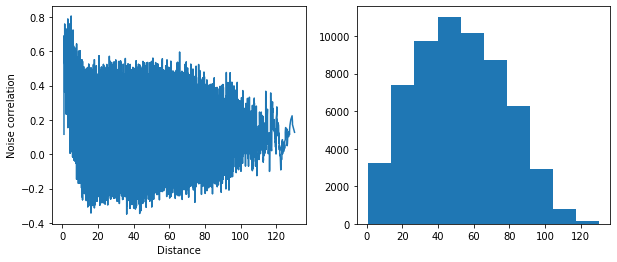

In [17]:
# ADDITIONAL CODE
# Plotting noise correlation

box = np.ones(8)/8

y_smooth = np.convolve(z_list[1][:], box, mode='same')

fig = plt.figure(figsize=(10,4))

fig.add_subplot(121)
plot(z_list[0][:],y_smooth)
xlabel('Distance')
ylabel('Noise correlation')

fig.add_subplot(122)
plt.hist(z_list[0][:],bins=10)

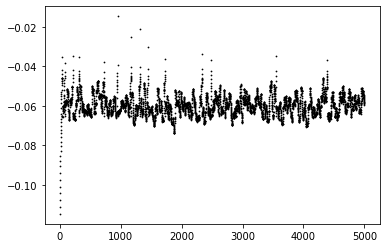

In [24]:
# ADDITIONAL CODE

plot(Ms_Ge[4].t/ms, Ms_Ge[3].V_e.T, 'k.', ms=1.5)


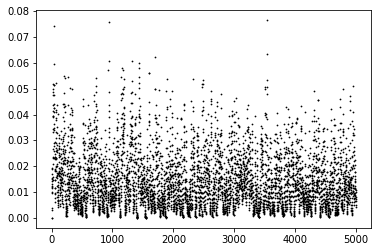

In [25]:
# ADDITIONAL CODE

plot(Ms_Ge[4].t/ms, Ms_Ge[3].I_e.T, 'k.', ms=1.5)


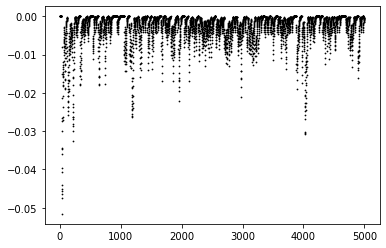

In [26]:
# ADDITIONAL CODE

plot(Ms_Ge[4].t/ms, Ms_Ge[3].I_ie.T, 'k.', ms=1.5)


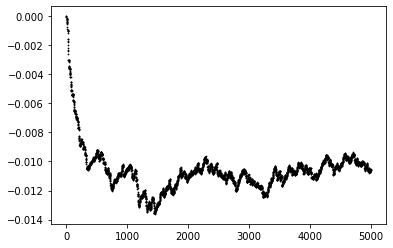

In [27]:
# ADDITIONAL CODE

plot(Ms_Ge[4].t/ms, Ms_Ge[3].I_a.T, 'k.', ms=1.5)
